In [83]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import torch
from torch import nn
from sklearn.metrics import accuracy_score
import pandas as pd
from helper import preprocess_text, preprocess_df
import numpy as np
from collections import Counter
from sklearn.metrics import confusion_matrix

## Load the test dataset

In [84]:
test = pd.read_csv("test_data.csv")

In [85]:
test = preprocess_df(test)

In [86]:
test = test.reset_index()

In [87]:
label_index = dict(zip(['answer', 'header', 'other', 'question'], range(4)))

In [88]:
test_label_ids = test['label'].map(lambda x: label_index[x]).values

## Baseline
Mark every label as `question`

In [89]:
accuracy_score(y_pred=[3]*len(test),y_true=test_label_ids)

0.4713656387665198

## Using the model

In [90]:
test = preprocess_df(test)

In [94]:
preprocessed_texts = preprocess_text(test['text']).values

In [95]:
model = AutoModelForSequenceClassification.from_pretrained("models/best")
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [96]:
with torch.no_grad():
    prediction_raw = [model(**tokenizer(str, truncation=True, return_tensors='pt')).logits for str in preprocessed_texts]

In [97]:
prediction_label = []
for i in prediction_raw:
    prediction_label.append(i.argmax())
prediction_label = np.array(prediction_label)

In [98]:
prediction_raw[:4]

[tensor([[-3.5352, -2.4019, -2.1327,  6.4319]]),
 tensor([[-3.3387, -2.6019, -1.9878,  6.3745]]),
 tensor([[-5.2360, -0.6580, -2.4960,  6.4828]]),
 tensor([[-3.3459, -2.6211, -1.8634,  6.3191]])]

In [99]:
prediction_label

array([3, 3, 3, ..., 0, 0, 3])

In [100]:
Counter(prediction_label)

Counter({3: 1039, 0: 834, 1: 115, 2: 282})

In [101]:
accuracy_score(y_pred=prediction_label,y_true=test_label_ids)

0.7986784140969163

### Error analysis

In [102]:
test['prediction'] = prediction_label
test['target_id'] = test_label_ids

In [103]:
mislabeled_df = test[test['prediction'] != test['target_id']]

In [104]:
mislabeled_df

,index,box,text,label,words,linking,id,file,prediction,target_id
5,5,"[209, 328, 256, 343]",Lorillard,answer,"[{'box': [209, 328, 256, 343], 'text': 'Lorill...","[[2, 5]]",5,83594639,1,0
7,7,"[638, 68, 673, 90]",☑001,other,"[{'box': [638, 68, 673, 90], 'text': '☑001'}]",[],7,83594639,0,2
9,9,"[338, 74, 481, 88]",ROPER STARCH WORLDWIDE,other,"[{'text': 'ROPER', 'box': [338, 75, 373, 86]},...",[],9,83594639,0,2
10,10,"[267, 109, 447, 168]",ROPER STARCH,header,"[{'text': 'ROPER', 'box': [279, 109, 427, 141]...",[],10,83594639,0,1
11,11,"[196, 186, 524, 203]",TURNING DATA INTO INTELLIGENCE WORLDWIDE,other,"[{'text': 'TURNING', 'box': [196, 186, 253, 20...",[],11,83594639,0,2
...,...,...,...,...,...,...,...,...,...,...
2239,2298,"[279, 705, 399, 720]",FOR CONTROL USE ONLY,header,"[{'text': 'FOR', 'box': [279, 705, 300, 718]},...","[[50, 51], [50, 52], [50, 53]]",50,86075409_5410,3,1
2245,2304,"[54, 839, 151, 857]",* Where Applicable,other,"[{'text': '*', 'box': [54, 839, 65, 850]}, {'t...",[],56,86075409_5410,3,2
2247,2307,"[77, 683, 166, 703]",APPROVALS,question,"[{'box': [77, 683, 166, 703], 'text': 'APPROVA...","[[2, 24], [2, 24]]",2,87125460,1,3
2262,2324,"[110, 270, 250, 292]",Page 14 and Table 4,answer,"[{'text': 'Page', 'box': [110, 272, 142, 290]}...","[[18, 19], [18, 19]]",19,87125460,2,0


In [105]:
confusion_matrix(y_true=test['target_id'].values, y_pred=test['prediction'])

array([[687,  19,  56,  47],
       [ 21,  46,   5,  47],
       [ 75,  14, 159,  24],
       [ 51,  36,  62, 921]])

In [106]:
mislabeled_df['target_id'].value_counts()

3    149
0    122
2    113
1     73
Name: target_id, dtype: int64

In [107]:
prediction_raw = torch.cat(prediction_raw)

In [135]:
missed_prediction = prediction_raw[mislabeled_df.index.values]

In [136]:
sm = nn.Softmax(dim=1)

In [138]:
missed_prediction

tensor([[-2.0285,  1.5704, -0.5854,  0.2602],
        [ 1.9063, -1.4393, -1.3599, -0.2412],
        [ 5.8454, -4.4767, -2.7974, -1.9164],
        ...,
        [-4.8892,  2.8709, -1.6743,  2.0851],
        [-0.6451, -5.1014,  5.1716, -1.6514],
        [-1.2490, -4.6066,  4.7553, -0.7553]])

In [144]:
sm_missed_prediction = sm(missed_prediction)

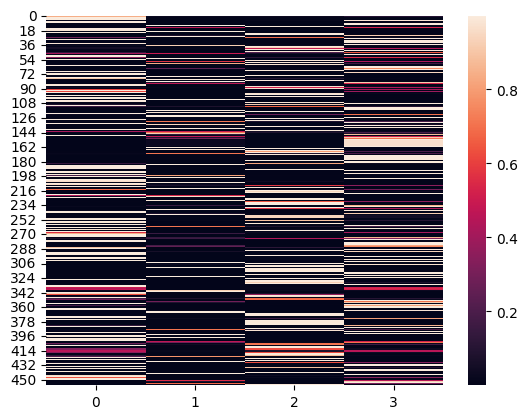

In [160]:
import seaborn as sns


ax = sns.heatmap(sm_missed_prediction)
  
plt.show()

<AxesSubplot: ylabel='Frequency'>

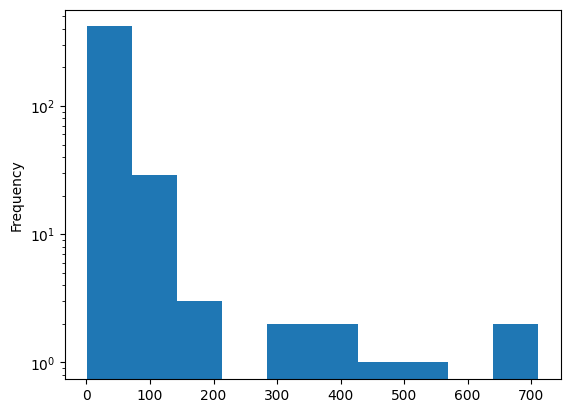

In [166]:
mislabeled_df['text'].str.len().plot(kind='hist', logy=True)